In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib as mpl

import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from gprofiler import GProfiler

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2
# logging
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.19.0 scipy==1.5.1 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1


In [2]:
# Setup file paths
DATA_PATH = '/n/home11/mjzhang/scTRS_data.080620'
# Please change this to your own path
RESULT_PATH = './figures/'
if not os.path.exists(RESULT_PATH):
    os.makedirs(RESULT_PATH)

In [3]:
# Helper function
from statsmodels.stats.multitest import multipletests
from scipy.stats import rankdata

def generate_null_genes(adata, gene_list, method, random_width=5):
    """
        Generate null gene set
        adata: AnnData
        gene_list: original gene list, should be a list of gene names
        method: One of 'mean_equal', 'mean_inflate'
        
        return a list of null genes
    """
    temp_df = pd.DataFrame(index=adata.var_names)
    temp_df['mean'] = np.array(adata.X.mean(axis=0)).reshape([-1])
    temp_df['rank'] = rankdata(temp_df['mean'], method='ordinal') - 1
    temp_df = temp_df.sort_values('rank')
    
    assert (method in ['mean_equal', 'mean_inflate']), "method must be in [mean_equal, mean_inflate]"
    
    if method == 'mean_equal':
        random_range = np.concatenate([np.arange(-random_width, 0), np.arange(1, random_width + 1)])
        
    if method == 'mean_inflate':
        random_range = np.arange(1, random_width + 1)
    
    # ordered gene_list
    gene_list_rank = sorted(temp_df.loc[gene_list, 'rank'].values)
    gene_list_null = []
    
    for rank in gene_list_rank:
        choices = set(rank + random_range) - set(gene_list_rank) - set(gene_list_null)
        gene_list_null.append(np.random.choice(list(choices)))
    
    # in case there is replicate / intersect with the gene_list_overlap
    gene_list_null = list(set(gene_list_null) - set(gene_list_rank))
    gene_list_null = temp_df.index[gene_list_null]
    
    return gene_list_null


def generate_null_dist(
               adata, 
               gene_list, 
               flag_correct_background=False,
               flag_nullgene=False,
               random_seed=0,
               verbose=True):
    
    """Generate null distributions
    
    Args:
        data (AnnData): AnnData object
            adata.X should contain size-normalized log1p transformed count data
        gene_list (list): gene list 
        flag_correct_background (bool):
            If normalize for background mean and std. If True, normalize by 
            score = (score - mean)/std
        tissue (str): 'all' or one of the facs or droplet tissues
        

    Returns:
        A dict with different null distributions
    """
    dic_null_dist = dict()
    np.random.seed(random_seed)
    gene_list_overlap = list(set(adata.var_names) & set(gene_list))
    if verbose:
        print('# generate_null_dist: %d/%d gene_list genes also in adata'
              %(len(gene_list), len(gene_list_overlap)))
        print('# generate_null_dist: flag_correct_background=%s'
              %(flag_correct_background))
        
    # Compute TRS with simple average
    dic_null_dist['TRS'] = adata[:, gene_list_overlap].X.mean(axis=1).A1
    
    if flag_nullgene:
        temp_df = pd.DataFrame(index=adata.var_names)
        temp_df['mean'] = np.array(adata.X.mean(axis=0)).reshape([-1])
    
        # A random set
        ind_select = np.random.permutation(adata.shape[1])[:len(gene_list_overlap)]
        gene_list_null = list(adata.var_names[ind_select])
        dic_null_dist['nullgene_random'] = adata[:, gene_list_null].X.mean(axis=1).A1
        
        # Random set with matching mean expression
        gene_list_null_me = generate_null_genes(adata, gene_list_overlap, method='mean_equal')
        dic_null_dist['nullgene_mean_equal'] = adata[:, gene_list_null_me].X.mean(axis=1).A1
        
        if verbose:
            print('# generate_null_dist: %d trait genes with mean_exp=%0.3f'
                   %(len(gene_list_overlap), temp_df.loc[gene_list_overlap,'mean'].values.mean()))
            print('# generate_null_dist: %d null_me genes with mean_exp=%0.3f'
                   %(len(gene_list_null_me), temp_df.loc[gene_list_null_me,'mean'].values.mean()))
        
    
    # Cell background correction
    if flag_correct_background:
        v_mean,v_var = util.get_sparse_var(adata.X, axis=1)
        v_std = np.sqrt(v_var)
        dic_null_dist['TRS'] = (dic_null_dist['TRS'] - v_mean) / v_std * \
                                np.sqrt(len(gene_list_overlap))
        if flag_nullgene:
            dic_null_dist['nullgene_random'] = \
                (dic_null_dist['nullgene_random'] - v_mean) / v_std * np.sqrt(len(gene_list_null))
            
            dic_null_dist['nullgene_mean_equal'] = \
                (dic_null_dist['nullgene_mean_equal'] - v_mean) / v_std * np.sqrt(len(gene_list_null_me))
    
    return dic_null_dist

In [4]:
# Count data (used for scoring genes)
start_time = time.time()
data_facs_ct = dl.load_tms_ct(DATA_PATH, data_name='facs')
print('# TMS facs count data: n_cell=%d, n_gene=%d'
      %(data_facs_ct.shape[0], data_facs_ct.shape[1]))
print('# time=%0.1fs'%(time.time() - start_time))

Trying to set attribute `.obs` of view, copying.


# TMS facs count data: n_cell=110096, n_gene=22966
# time=95.4s


In [5]:
# Get 64 independent traits 
df_sumstats_meta = pd.read_excel(DATA_PATH+'/sumstats/Description_080419.xlsx',
                                 sheet_name='64 Recommended indepent traits')
df_sumstats_meta = df_sumstats_meta[['Trait_Identifier', 'h2g', 'Z', 'N']]

# MAGMA gene annotation
df_geneannot = pd.read_csv(DATA_PATH+'/gene_annotation/Genes_by_X_kushal/Genes_by_X_MAGMA_10kb_Z.txt', sep='\t')
print('# MAGMA annotation: n_gene=%d, n_trait=%d'%(df_geneannot.shape[0], df_geneannot.shape[1]))

# Ortholog genes 
# (computed using following two lines of codes, stored to void dulplicated computation )
# gp = GProfiler(return_dataframe=True)
# df_orth = gp.orth(organism='hsapiens', query=list(df_geneannot.index), target='mmusculus')
df_orth = pd.read_csv(DATA_PATH+'/gene_annotation/Genes_by_X_kushal/Genes_by_X_MAGMA_10kb_Z.orth.txt', sep='\t')

# Use only human genes that can be uniquely mapped to a mouse gene
temp_df = df_orth.groupby(['incoming']).agg({'name':len})
gene_list = list(temp_df.index[temp_df['name']==1])
gene_list.sort()
df_orth.index = df_orth['incoming']
df_orth = df_orth.loc[gene_list]
print('# MAGMA annotation: n_mouse_gene_converted=%d'%(df_orth.shape[0]))

# Change df_geneannot genes to mouse genes
dic_mapping = {df_orth['incoming'].values[x]:df_orth['name'].values[x] for x in np.arange(df_orth.shape[0])}
df_geneannot = df_geneannot.loc[gene_list]
df_geneannot.index = [dic_mapping[x] for x in df_geneannot.index]

# MAGMA annotation: n_gene=19427, n_trait=169
# MAGMA annotation: n_mouse_gene_converted=15832


In [6]:
trait_list = ['PASS_MDD_Wray2018', 'PASS_ADHD_Demontis2018', 'PASS_SCZvsBD_Ruderfer2018',
              'PASS_Coronary_Artery_Disease', 'PASS_CardioembolicStroke_Malik2018', 'PASS_LDL',
              'PASS_Rheumatoid_Arthritis', 'PASS_IBD_deLange2017', 'PASS_Type_1_Diabetes']

tissue_list = list(set(data_facs_ct.obs['tissue']))
tissue_list.sort()
tc_list = list(set(data_facs_ct.obs['tissue_celltype']))
tc_list.sort()

print('# facs data: n_tissue=%d n_tissue_celltype=%d'%(len(tissue_list), len(tc_list)))

# facs data: n_tissue=23 n_tissue_celltype=207


In [7]:
# Assign TRS
dic_null_dist = dict()
for trait in trait_list:
    
    # Find FDR<0.1 genes 
    temp_v = np.absolute(df_geneannot[trait].values)
    temp_v = 1 - sp.stats.norm.cdf(temp_v)
    temp_v = multipletests(temp_v, method='fdr_bh')[1]
    gene_list = list(df_geneannot.index[temp_v<0.1])
    print('# trait=%-40s FDR<0.1 genes=%d'%(trait, len(gene_list)))
    dic_null_dist[trait] = generate_null_dist(data_facs_ct, gene_list,
                                            flag_correct_background=True,
                                            flag_nullgene=True,
                                            random_seed=1)

# trait=PASS_MDD_Wray2018                        FDR<0.1 genes=128
# generate_null_dist: 128/117 gene_list genes also in adata
# generate_null_dist: flag_correct_background=True
# generate_null_dist: 117 trait genes with mean_exp=0.120
# generate_null_dist: 117 null_me genes with mean_exp=0.119
# trait=PASS_ADHD_Demontis2018                   FDR<0.1 genes=236
# generate_null_dist: 236/214 gene_list genes also in adata
# generate_null_dist: flag_correct_background=True
# generate_null_dist: 214 trait genes with mean_exp=0.142
# generate_null_dist: 214 null_me genes with mean_exp=0.142
# trait=PASS_SCZvsBD_Ruderfer2018                FDR<0.1 genes=271
# generate_null_dist: 271/256 gene_list genes also in adata
# generate_null_dist: flag_correct_background=True
# generate_null_dist: 256 trait genes with mean_exp=0.136
# generate_null_dist: 256 null_me genes with mean_exp=0.136
# trait=PASS_Coronary_Artery_Disease             FDR<0.1 genes=165
# generate_null_dist: 165/155 gene_list genes

PASS_MDD_Wray2018


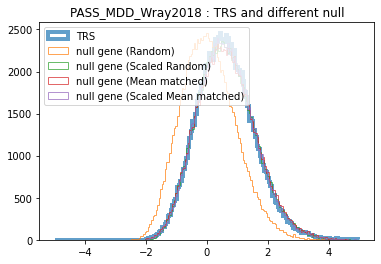

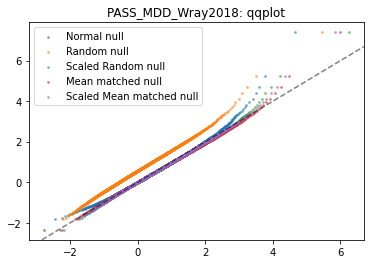

PASS_ADHD_Demontis2018


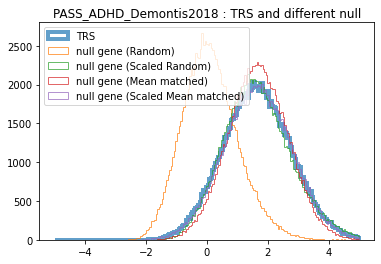

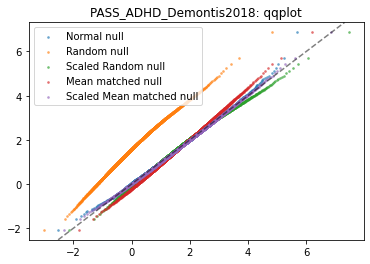

PASS_SCZvsBD_Ruderfer2018


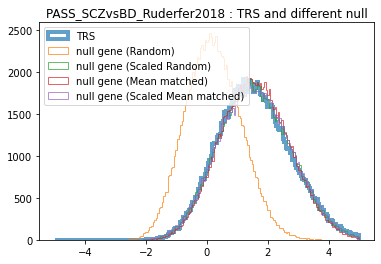

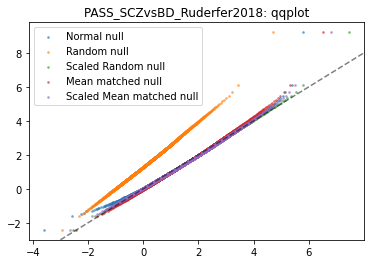

PASS_Coronary_Artery_Disease


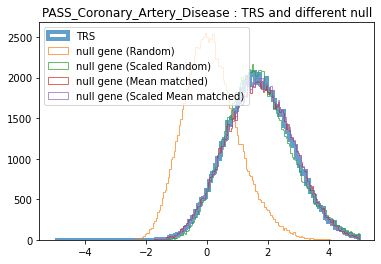

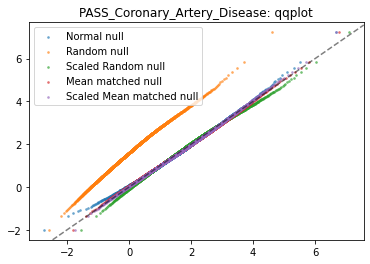

PASS_CardioembolicStroke_Malik2018


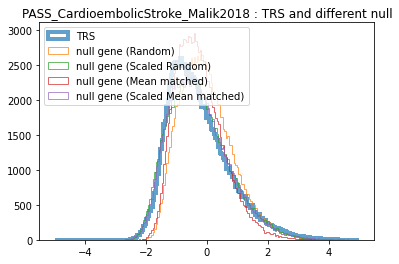

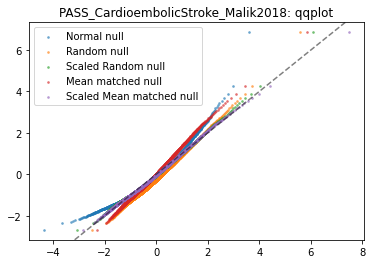

PASS_LDL


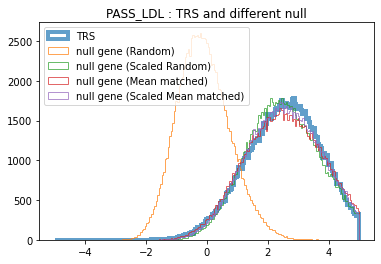

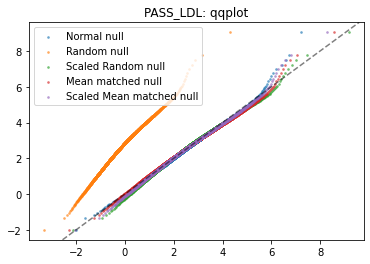

PASS_Rheumatoid_Arthritis


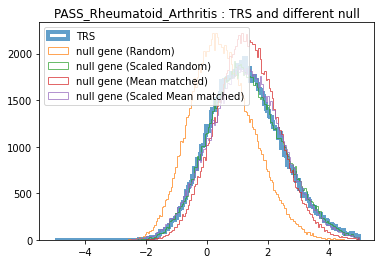

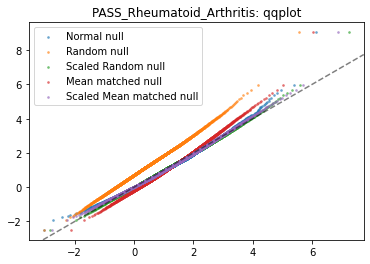

PASS_IBD_deLange2017


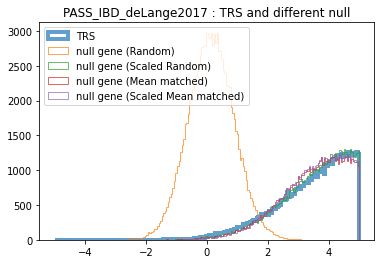

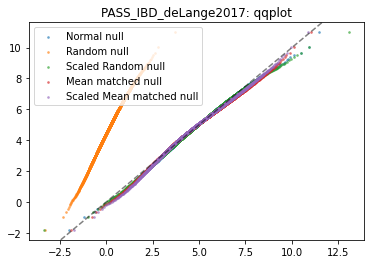

PASS_Type_1_Diabetes


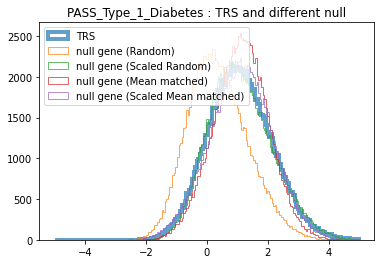

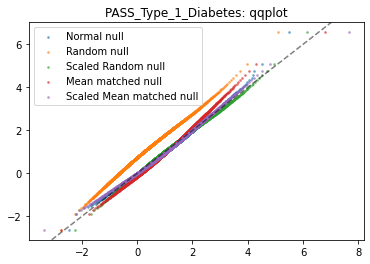

In [9]:
# Look at the score distribution

# whether to save figures or not
SAVE_RESULTS=False

plot_alpha = 0.7
for trait in trait_list:
    print(trait)
    bins_ = np.linspace(-5,5,200)
    fig = plt.figure()
    # original TRS
    trs_score = dic_null_dist[trait]['TRS']
    plt.hist(trs_score, histtype='step', 
             bins=bins_, alpha=plot_alpha, label='TRS', linewidth=4)
    # Random, mean_equal
    for suffix, label in zip(['random', 'mean_equal'], ['Random', 'Mean matched']):
        random_score = dic_null_dist[trait][f'nullgene_{suffix}']
        # translate / scale to have equal mean and variance
        scaled_random_score = (random_score - random_score.mean()) / random_score.std() * \
            trs_score.std() + trs_score.mean()
        plt.hist(random_score, histtype='step',
                 bins=bins_, label=f'null gene ({label})', alpha=plot_alpha)
        plt.hist(scaled_random_score, histtype='step',
                 bins=bins_, label=f'null gene (Scaled {label})', alpha=plot_alpha)
    
    plt.legend(loc='upper left')
    plt.title(f'{trait} : TRS and different null')
    
    if SAVE_RESULTS:
        plt.savefig(os.path.join(RESULT_PATH, f'trs_dist_{trait}.png'), dpi=150)
        plt.close(fig)
    else:
        plt.show()
    

    # QQ plot
    fig = plt.figure()
    # normal null
    normal_x = np.random.normal(size=10000) * trs_score.std() + trs_score.mean()
    util.qqplot(x=normal_x, y=trs_score, quantiles=2000, s=3, label='Normal null', alpha=0.5)
    
    for suffix, label in zip(['random', 'mean_equal'], ['Random', 'Mean matched']):
        random_score = dic_null_dist[trait][f'nullgene_{suffix}']
        # translate / scale to have equal mean and variance
        scaled_random_score = (random_score - random_score.mean()) / random_score.std() * \
            trs_score.std() + trs_score.mean()
        util.qqplot(x=random_score, y=trs_score, quantiles=2000, s=3, label=f'{label} null', alpha=0.5)
        util.qqplot(x=scaled_random_score, y=trs_score, quantiles=2000, s=3, label=f'Scaled {label} null', alpha=0.5)
    plt.axline((1, 1), slope=1, linestyle='--', color='k', alpha=0.5)
    plt.legend(loc='upper left')
    plt.title(f'{trait}: qqplot')
    if SAVE_RESULTS:
        plt.savefig(os.path.join(RESULT_PATH, f'trs_qqplot_{trait}.png'), dpi=150)
        plt.close(fig)
    else:
        plt.show()

In [ ]:
# import ipyplot
# image_list = np.concatenate([[f'trs_dist_{trait}.png', f'trs_qqplot_{trait}.png'] for trait in trait_list])
# image_list = [os.path.join(RESULT_PATH, i) for i in image_list]

# ipyplot.plot_images(image_list, img_width=700, force_b64=True)

# Cell-trait association

In [10]:
fdr_thres = 0.2
df_obs = data_facs_ct.obs.copy()

dic_tissue_assoc = dict()
dic_tc_assoc = dict()

for null_type in ['normal', 'scaled_random', 'mean_equal', 'scaled_mean_equal']:

    tissue_assoc = pd.DataFrame(index=tissue_list, columns=trait_list, data=0)
    tc_assoc = pd.DataFrame(index=tc_list, columns=trait_list, data=0)
    for trait in trait_list:
        trs = dic_null_dist[trait]['TRS']
        if null_type == 'normal':
            # z-score the TRS and get the significance
            zsc = (trs - trs.mean()) / trs.std()
        else:
            # use null distribution to assign a z-score
            if null_type == 'scaled_random':
                null_dist = dic_null_dist[trait]['nullgene_random']
                null_dist = (null_dist - null_dist.mean()) / null_dist.std() * \
                    trs.std() + trs.mean()
            elif null_type == 'mean_equal':
                null_dist = dic_null_dist[trait]['nullgene_mean_equal']
            elif null_type == 'scaled_mean_equal':
                null_dist = dic_null_dist[trait]['nullgene_mean_equal']
                null_dist = (null_dist - null_dist.mean()) / null_dist.std() * \
                    trs.std() + trs.mean()
            else:
                raise ValueError
            # use null_dist to assign z-score and pvalue
            zsc = util.empirical_zsc(score=trs, null=null_dist)

        # one sided p-value
        p = 1 - sp.stats.norm.cdf(zsc)
        bhp =  multipletests(p, method='fdr_bh')[1]
        df_obs['bhp'] = bhp

        temp_df = df_obs.loc[df_obs['bhp']<fdr_thres].copy()
        temp_df = temp_df.groupby(['tissue']).agg({'cell':len})
        temp_df = temp_df.loc[~temp_df['cell'].isna()]
        tissue_assoc.loc[temp_df.index, trait] = temp_df['cell'].values

        temp_df = df_obs.loc[df_obs['bhp']<fdr_thres].copy()
        temp_df = temp_df.groupby(['tissue_celltype']).agg({'cell':len})
        temp_df = temp_df.loc[~temp_df['cell'].isna()]
        tc_assoc.loc[temp_df.index, trait] = temp_df['cell'].values
        
    # also add total number of cells, per tissue and per tissue_celltype
    temp_df = df_obs.groupby(['tissue']).agg({'cell':len})
    assert((tissue_assoc.index == temp_df.index).all())
    tissue_assoc.index = tissue_assoc.index + ' (' + temp_df['cell'].values.astype(str) + ')'
    
    temp_df = df_obs.groupby(['tissue_celltype']).agg({'cell':len})
    assert((tc_assoc.index == temp_df.index).all())
    tc_assoc.index = tc_assoc.index + ' (' + temp_df['cell'].values.astype(str) + ')'
    
    
    dic_tissue_assoc[null_type] = tissue_assoc
    dic_tc_assoc[null_type] = tc_assoc

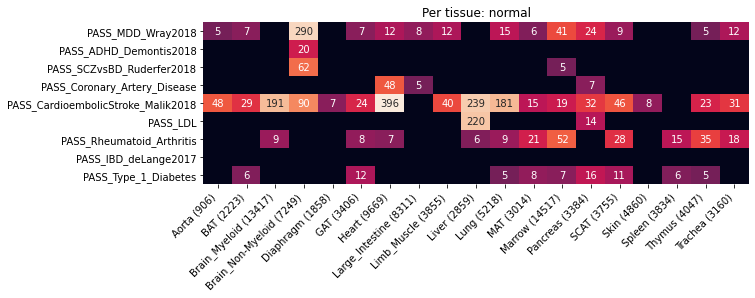

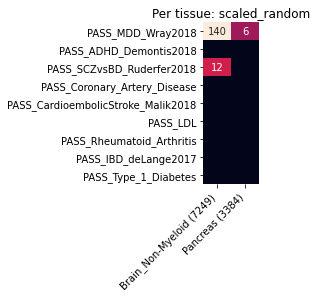

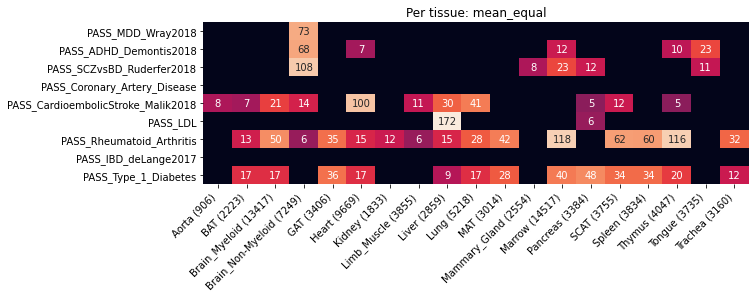

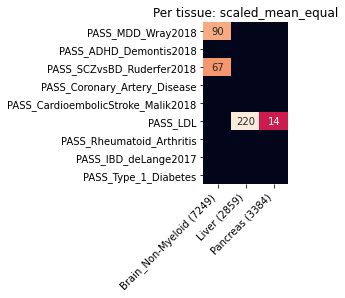

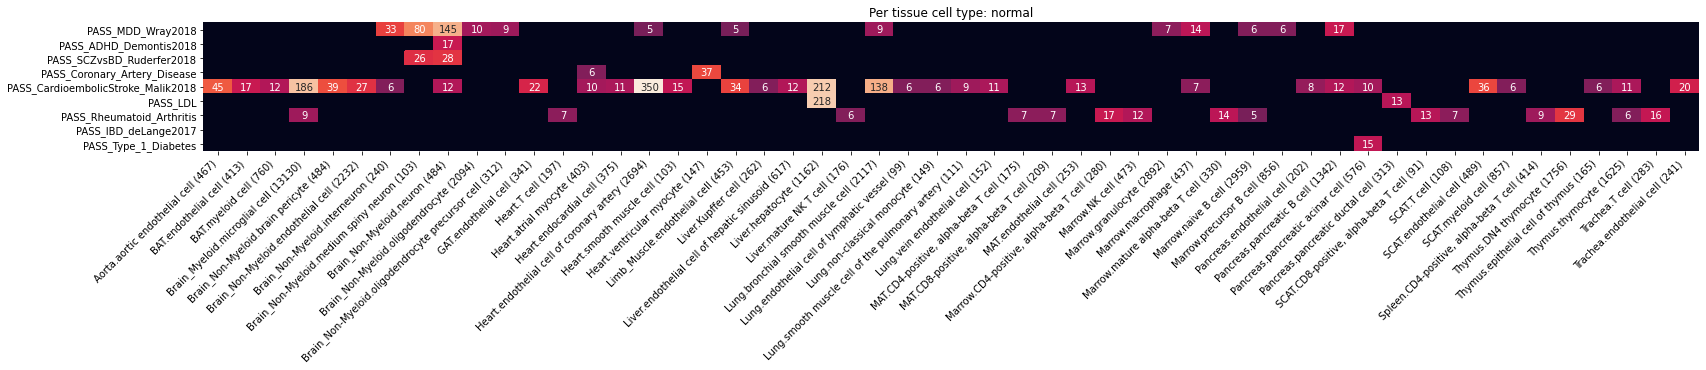

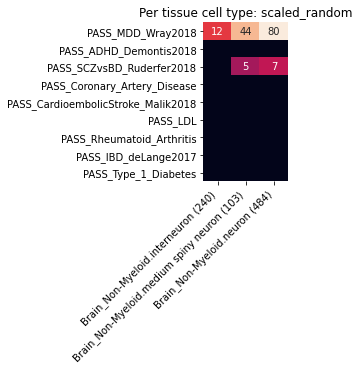

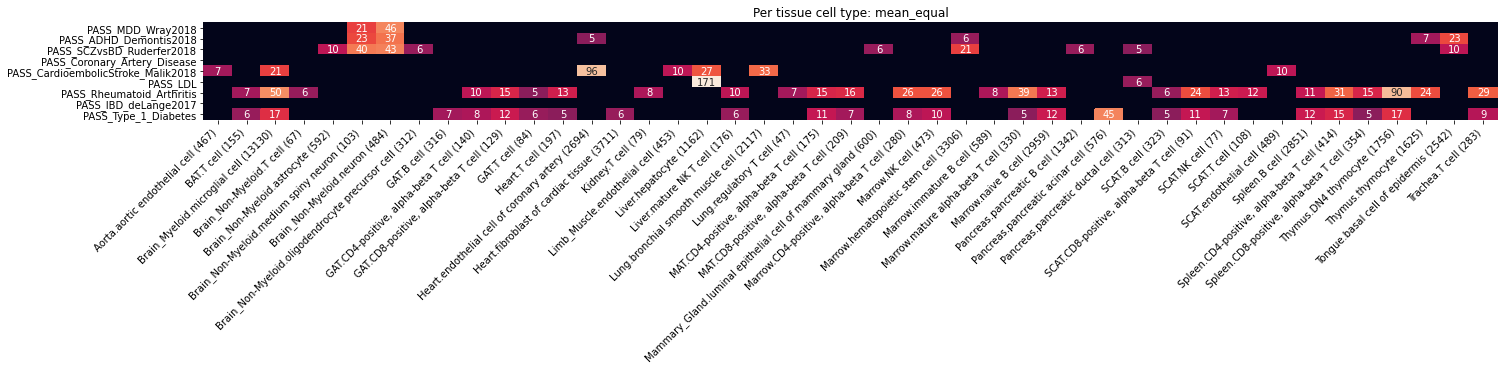

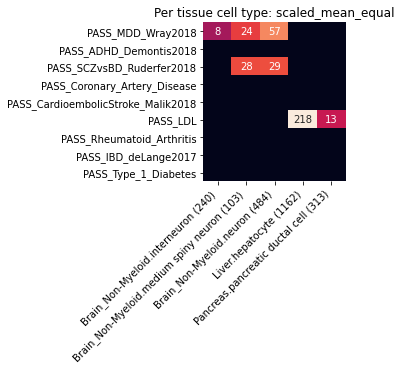

In [11]:
def num2str(x):
    if x>1000:
        return '%0.1fk'%(x/1000)
    elif x>0:
        return '%d'%x
    else:
        return ''
    

# per tissue    
for null_type in dic_tissue_assoc:

    df_plot = dic_tissue_assoc[null_type].copy()
    df_plot = df_plot.loc[df_plot.max(axis=1)>5]
    df_plot = df_plot.T
    df_plot[df_plot<5] = 0
    
    mat_annot = np.zeros(df_plot.shape, dtype=object)
    for i_col,col in enumerate(df_plot.columns):
        mat_annot[:,i_col] = [num2str(x) for x in df_plot[col].values]
    df_plot = np.log10(df_plot+1)
    
    plt.figure(figsize=[0.4*df_plot.shape[1]+3, 0.25*df_plot.shape[0]+2])
    sns.heatmap(df_plot, annot=mat_annot, fmt='s', cbar=False)
    plt.xticks(np.arange(df_plot.shape[1])+0.5, df_plot.columns, rotation=45, ha='right')
    plt.title(f'Per tissue: {null_type}')
    plt.tight_layout()
    plt.show()

# per cell type
for null_type in dic_tc_assoc:

    df_plot = dic_tc_assoc[null_type].copy()
    df_plot = df_plot.loc[df_plot.max(axis=1)>5]
    df_plot = df_plot.T
    df_plot[df_plot<5] = 0
    
    mat_annot = np.zeros(df_plot.shape, dtype=object)
    for i_col,col in enumerate(df_plot.columns):
        mat_annot[:,i_col] = [num2str(x) for x in df_plot[col].values]
    df_plot = np.log10(df_plot+1)
    
    plt.figure(figsize=[0.4*df_plot.shape[1]+3, 0.25*df_plot.shape[0]+2+1])
    sns.heatmap(df_plot, annot=mat_annot, fmt='s', cbar=False)
    plt.xticks(np.arange(df_plot.shape[1])+0.5, df_plot.columns, rotation=45, ha='right')
    plt.title(f'Per tissue cell type: {null_type}')
    plt.tight_layout()
    plt.show()